In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/LGAimers/Data/train.csv") # 학습용 데이터
df_test = pd.read_csv("/content/drive/MyDrive/LGAimers/Data/submission.csv") # 테스트 데이터(제출파일의 데이터)

In [ ]:
# inqury_type 소문자 변환 밑 '_'기호 없애기
for column in df_train.columns:
    # 컬럼 데이터 타입이 문자열인 경우에만 변환을 수행
    if df_train[column].dtype == 'object':
        df_train[column] = df_train[column].str.lower().str.replace('_', ' ')

In [ ]:
df_test = df_test.drop("id", axis=1)
df = pd.concat([df_train, df_test], ignore_index=True)

In [ ]:
# inqury_type 소문자 변환 밑 '_'기호 없애기
for column in df.columns:
    # 컬럼 데이터 타입이 문자열인 경우에만 변환을 수행
    if df[column].dtype == 'object':
        df[column] = df[column].str.lower().str.replace('_', ' ')

In [ ]:
df_train.isnull().sum()

bant_submit                    0
customer_country             982
business_unit                  0
com_reg_ver_win_rate       44731
customer_idx                   0
customer_type              43961
enterprise                     0
historical_existing_cnt    45543
id_strategic_ver           55855
it_strategic_ver           58178
idit_strategic_ver         54734
customer_job               18733
lead_desc_length               0
inquiry_type                 941
product_category           19374
product_subcategory        50064
product_modelname          50070
customer_country.1           982
customer_position              0
response_corporate             0
expected_timeline          30863
ver_cus                        0
ver_pro                        0
ver_win_rate_x             40882
ver_win_ratio_per_bu       43995
business_area              40882
business_subarea           53773
lead_owner                     0
is_converted                   0
dtype: int64

In [ ]:
df_train.head(3)

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,...,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,1.0,/quezon city/philippines,as,0.066667,32160,end-customer,enterprise,NaN,NaN,NaN,...,lgeph,less than 3 months,1,0,0.003079,0.026846,corporate / office,engineering,0,True
1,1.0,/ph-00/philippines,as,0.066667,23122,end-customer,enterprise,12.0,NaN,NaN,...,lgeph,less than 3 months,1,0,0.003079,0.026846,corporate / office,advertising,1,True
2,1.0,/kolkata /india,as,0.088889,1755,end-customer,enterprise,144.0,NaN,NaN,...,lgeil,less than 3 months,1,0,0.003079,0.026846,corporate / office,construction,2,True


In [ ]:
def visualize_top_categories_by_conversion_with_ratio(df, column_name, top_n=10, target='is_converted'):
    # 상위 N개의 카테고리 선택
    top_categories = df[column_name].value_counts().head(top_n).index

    # 각 카테고리 별로 target의 True, False 개수 집계
    agg_df = df[df[column_name].isin(top_categories)].groupby([column_name, target]).size().unstack(fill_value=0)

    # True와 False의 합계를 기준으로 내림차순 정렬
    agg_df['total'] = agg_df.sum(axis=1)
    agg_df_sorted = agg_df.sort_values(by='total', ascending=False).drop('total', axis=1)

    # Stacked bar plot 시각화
    ax = agg_df_sorted.plot(kind='barh', stacked=True, figsize=(10, 6))
    plt.title(f'Top {top_n} {column_name} by Conversion Status - Descending Order')
    plt.xlabel('Count')
    plt.ylabel(column_name)
    plt.legend(title='Is Converted', labels=['False', 'True'], loc='lower right')
    plt.gca().invert_yaxis()  # y축의 순서를 뒤집어 내림차순으로 표시

    # True Ratio 값을 막대 위에 표시
    for index, (category, row) in enumerate(agg_df_sorted.iterrows()):
        total_count = row.sum()
        true_ratio = row[True] / total_count if total_count > 0 else 0
        # 막대의 오른쪽 끝에 True Ratio 텍스트 추가
        ax.text(row.sum(), index, f' True Ratio: {true_ratio:.2f}', va='center', ha='left')

    # # 각 막대의 끝에 Total Count 텍스트 추가
    # for p in ax.patches:
    #     ax.text(p.get_width(), p.get_y() + p.get_height() / 2, f' {int(p.get_width())}', va='center')

    plt.show()

In [ ]:
def show_binary_ratio_sorted(df_input, selected_columns: list, target: str, n: int):
    for column in selected_columns:
        print(f'{column}: {df_input[column].notnull().sum()}')

        # Get unique values in the column
        unique_values = df_input[column].dropna().unique()
        value_ratios_counts = []

        for value in unique_values:
            # For each unique value, count occurrences of target 0 and 1
            count_0 = df_input[(df_input[column] == value) & (df_input[target] == False)].shape[0]
            count_1 = df_input[(df_input[column] == value) & (df_input[target] == True)].shape[0]
            count_01 = count_0 + count_1
            true_ratio = count_1 / count_01 if count_01 > 0 else 0

            value_ratios_counts.append((value, true_ratio, count_01))

        # Get unique values in the column
        unique_values = sorted(df_input[column].dropna().unique())
        longest_str = max(len(f"    {value}" ) for value in unique_values)

        # Sort by  Total Count respectively
        sorted_by_total_count = sorted(value_ratios_counts, key=lambda x: x[2], reverse=True)[:n]

        # Print sorted by Total Count
        print(f'<Top 15 by Total Count in {column}:>')
        for value, ratio, count in sorted_by_total_count:
            print(f'    {value}'.ljust(longest_str), end=' ')
            print(f'True Ratio : {ratio:.2f}, Total Count : {count}')

        # Print a blank line for better readability between columns
        print()

In [ ]:
df_train['product_category'].value_counts()

interactive digital board                     6154
vrf                                           5640
multi-split                                   3674
video wall signage                            2029
etc.                                          2018
                                              ... 
system ac                                        1
sac                                              1
gscd046                                          1
43uh5f-h.awzm                                    1
monior/monitor tv,refrigerator,audio/video       1
Name: product_category, Length: 357, dtype: int64

In [ ]:
df_train['product_category'].unique()

array(['multi-split', 'single-split', 'vrf', 'chiller', 'etc.', 'rac',
       'teto ou cassete inverter', nan, 'software solution',
       'all lg vrf systems', 'ventilation',
       'a thermodynamic water heater', 'residential air conditioner',
       'outros', 'heating', 'multi v5 vrf', 'split tunggal',
       'multi inverter', 'חימום', 'standard signage',
       'high brightness signage', 'interactive signage',
       'video wall signage', 'led signage', 'hotel tv',
       'signage care solution', 'oled signage', 'idb', 'video wall',
       'one:quick series', 'commercial tv', 'lg one:quick',
       'special signage', 'other', 'accessories', 'commercial display',
       'interactive digital board', 'standard', 'uhd signage',
       'smart tv signage', 'lg one:quick series', 'pro:centric', 'ur640',
       'ur640s', 'webos', 'signage care solutions', 'aio | one quick',
       'high brightness', 'hospital tv', 'digital signage', 'monitor',
       'pc', 'laptop', 'projector', 'cloud dev

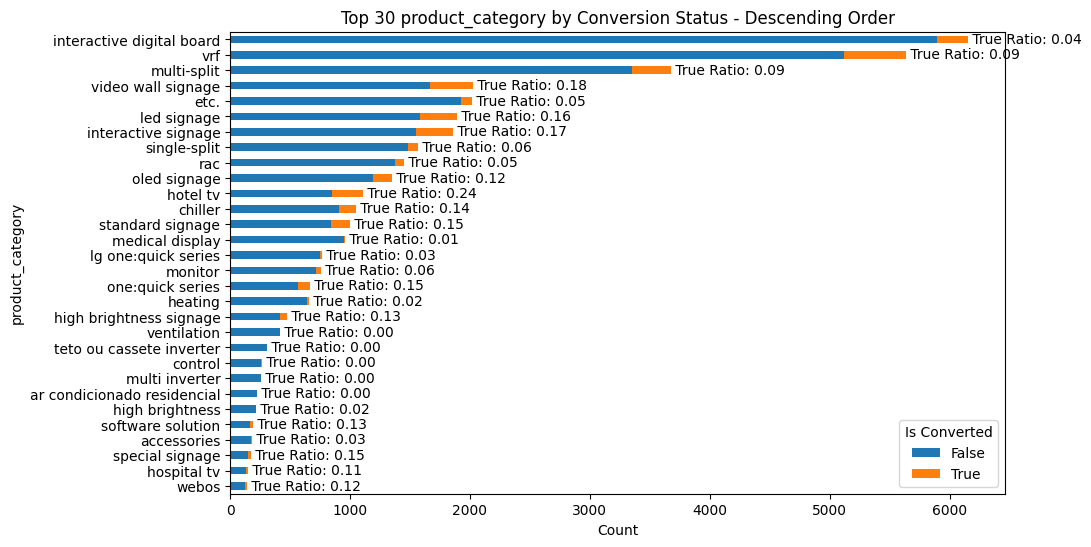

product_category: 39925
<Top 15 by Total Count in product_category:>
    interactive digital board                                                                            True Ratio : 0.04, Total Count : 6154
    vrf                                                                                                  True Ratio : 0.09, Total Count : 5640
    multi-split                                                                                          True Ratio : 0.09, Total Count : 3674
    video wall signage                                                                                   True Ratio : 0.18, Total Count : 2029
    etc.                                                                                                 True Ratio : 0.05, Total Count : 2018
    led signage                                                                                          True Ratio : 0.16, Total Count : 1895
    interactive signage                                                  

In [ ]:
#train_data내에서 product_category의 target비율 확인

visualize_top_categories_by_conversion_with_ratio(df_train, 'product_category', top_n=30, target='is_converted')

#train_data내에서 product_category의 target비율 상위 30개 확인 (True Ratio 기준 상위 30개, 데이터 수 기준 상위 30개)

show_binary_ratio_sorted(df_train, ['product_category'], target='is_converted',n=30)

In [ ]:
#클러스터
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np



raw_corpus = df['product_category']
raw_corpus = raw_corpus.dropna().reset_index(drop=True)

# TF-IDF 벡터라이저 초기화 및 변환 수행
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(raw_corpus)

# 적절한 클러스터 수를 정하기 (예: 5로 설정)
true_k = 7
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

# 각 클러스터에 대한 상위 단어 출력
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(true_k):
    print(f"Cluster {i}:")
    for ind in order_centroids[i, :10]:  # 상위 10개 단어
        print(f' {terms[ind]}')
    print()

Top terms per cluster:
Cluster 0:
 medical
 display
 monitor
 高亮度顯示屏
 essential
 education
 ems
 energy
 enfriadoras
 error

Cluster 1:
 signage
 led
 video
 wall
 rac
 oled
 chiller
 tv
 standard
 series

Cluster 2:
 vrf
 chiller
 heating
 multi
 ess
 education
 ems
 energy
 enfriadoras
 error

Cluster 3:
 multi
 split
 vrf
 heating
 chiller
 education
 ems
 energy
 enfriadoras
 error

Cluster 4:
 board
 digital
 interactive
 高亮度顯示屏
 education
 ems
 energy
 enfriadoras
 error
 ess

Cluster 5:
 interactive
 signage
 高亮度顯示屏
 dụng
 education
 ems
 energy
 enfriadoras
 error
 ess

Cluster 6:
 single
 split
 vrf
 multi
 chiller
 heating
 education
 ems
 energy
 enfriadoras



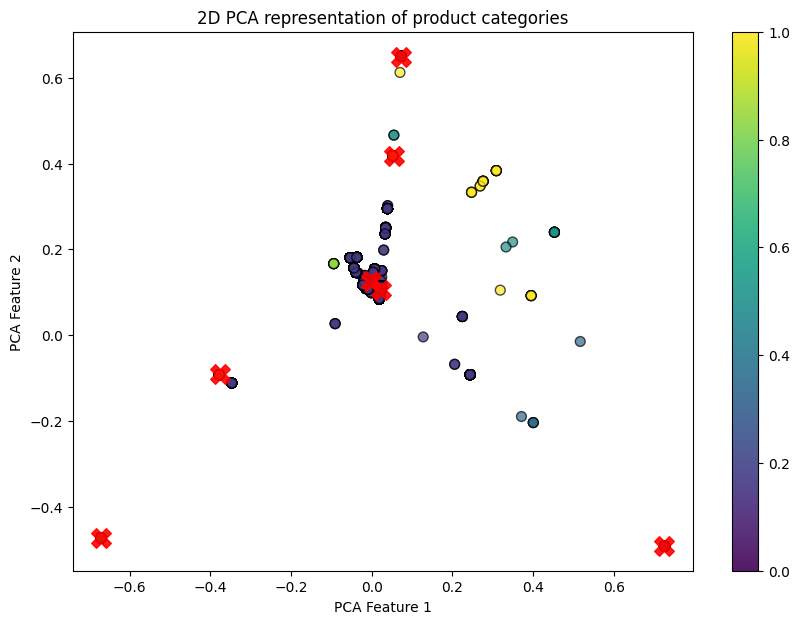

In [ ]:
from sklearn.decomposition import PCA

labels = model.labels_
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X.toarray())

# 클러스터링 결과 시각화
plt.figure(figsize=(10, 7))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis', marker='o', edgecolor='k', s=50, alpha=0.7)

# 클러스터 중심 시각화
centers = pca.transform(model.cluster_centers_)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.9, marker='X')

plt.title('2D PCA representation of product categories')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.colorbar()
plt.show()

In [ ]:
# 'product_category' 컬럼 원소 내 첫 단어로 치환 및 others 처리
df_train['product_category'] = df_train['product_category'].apply(lambda x: x.split(',')[0] if pd.notnull(x) else x)
df_train['product_category'] = df_train['product_category'].replace(['other', 'etc', 'etc.'], 'others')

print(df_train['product_category'].unique())
print(df_train['product_category'].value_counts())

['multi-split' 'single-split' 'vrf' 'chiller' 'others' 'rac'
 'teto ou cassete inverter' nan 'software solution' 'all lg vrf systems'
 'ventilation' 'a thermodynamic water heater'
 'residential air conditioner' 'outros' 'heating' 'multi v5 vrf'
 'split tunggal' 'multi inverter' 'חימום' 'standard signage'
 'high brightness signage' 'interactive signage' 'video wall signage'
 'led signage' 'hotel tv' 'signage care solution' 'oled signage' 'idb'
 'video wall' 'one:quick series' 'commercial tv' 'lg one:quick'
 'special signage' 'accessories' 'commercial display'
 'interactive digital board' 'standard' 'uhd signage' 'smart tv signage'
 'lg one:quick series' 'pro:centric' 'ur640' 'ur640s' 'webos'
 'signage care solutions' 'aio | one quick' 'high brightness'
 'hospital tv' 'digital signage' 'monitor' 'pc' 'laptop' 'projector'
 'cloud device' 'medical display' 'washing machine' 'solar' 'system ac'
 'monitor signage' 'aircare' 'monior/monitor tv' 'ultra stretch series'
 '互動式顯示屏' 'led 顯示屏' 'one 

In [ ]:
show_binary_ratio_sorted(df_train, ['product_category'], target='is_converted',n=240)

product_category: 39925
<Top 15 by Total Count in product_category:>
    interactive digital board                            True Ratio : 0.04, Total Count : 6154
    vrf                                                  True Ratio : 0.10, Total Count : 5677
    multi-split                                          True Ratio : 0.09, Total Count : 3675
    others                                               True Ratio : 0.04, Total Count : 2047
    video wall signage                                   True Ratio : 0.18, Total Count : 2029
    led signage                                          True Ratio : 0.16, Total Count : 1895
    interactive signage                                  True Ratio : 0.17, Total Count : 1862
    single-split                                         True Ratio : 0.06, Total Count : 1569
    rac                                                  True Ratio : 0.05, Total Count : 1447
    oled signage                                         True Ratio : 0.12, 

In [ ]:
#'product_category'컬럼 내 영어 외 외국어 삭제
df_train['product_category'] = df_train['product_category'].apply(lambda x: np.nan if not pd.isna(x) and not pd.Series(x).str.contains('^[A-Za-z0-9,.\- ]*$', regex=True).all() else x)

# 수정된 데이터 프레임 출력
print(df_train['product_category'].unique())
print(df_train['product_category'].value_counts())

['multi-split' 'single-split' 'vrf' 'chiller' 'others' 'rac'
 'teto ou cassete inverter' nan 'software solution' 'all lg vrf systems'
 'ventilation' 'a thermodynamic water heater'
 'residential air conditioner' 'outros' 'heating' 'multi v5 vrf'
 'split tunggal' 'multi inverter' 'standard signage'
 'high brightness signage' 'interactive signage' 'video wall signage'
 'led signage' 'hotel tv' 'signage care solution' 'oled signage' 'idb'
 'video wall' 'commercial tv' 'special signage' 'accessories'
 'commercial display' 'interactive digital board' 'standard' 'uhd signage'
 'smart tv signage' 'ur640' 'ur640s' 'webos' 'signage care solutions'
 'high brightness' 'hospital tv' 'digital signage' 'monitor' 'pc' 'laptop'
 'projector' 'cloud device' 'medical display' 'washing machine' 'solar'
 'system ac' 'monitor signage' 'aircare' 'ultra stretch series'
 'one quick works' 'fhd series' 'onequick series' '43us660h0sd.awz'
 '50uq801c0sb.bwz' 'led aio 136' 'aio' 'tv' 'videowall signage' 'robots'
 '

In [ ]:
import re

#'product_category'비슷한 값 묶기
df_train['product_category'] = df_train['product_category'].apply(
    lambda x: 'display' if re.match('^\d', str(x)) else x)
df_train['product_category'] = df_train['product_category'].apply(
    lambda x: 'display' if 'display' in str(x).lower() else x)
df_train['product_category'] = df_train['product_category'].apply(
    lambda x: 'monitor' if 'monitor' in str(x).lower() else x)
df_train['product_category'] = df_train['product_category'].apply(
    lambda x: 'tv' if 'tv' in str(x).lower() else x)
df_train['product_category'] = df_train['product_category'].apply(
    lambda x: 'vrf' if 'vrf' in str(x).lower() else x)
df_train['product_category'] = df_train['product_category'].apply(
    lambda x: 'signage' if any(keyword in str(x).lower() for keyword in ['signage','ultra stretch series']) else x)
df_train['product_category'] = df_train['product_category'].apply(
    lambda x: 'multi-split' if any(keyword in str(x).lower() for keyword in ['multi-split','multi split']) else x)
df_train['product_category'] = df_train['product_category'].apply(
    lambda x: 'single-split' if any(keyword in str(x).lower() for keyword in ['single-split','single split']) else x)
df_train['product_category'] = df_train['product_category'].apply(
    lambda x: 'video wall' if any(keyword in str(x).lower() for keyword in ['video wall','videwall','videowall rmk']) else x)

# df_train['product_category'] = df_train['product_category'].apply(
#     lambda x: 'display' if any(keyword in str(x).lower() for keyword in ['display', 'signage','led', 'video', 'oled', 'tv','board','monitor']) or re.match('^\d', str(x)) else x)
# df_train['product_category'] = df_train['product_category'].apply(
#     lambda x: 'hvac' if any(keyword in str(x).lower() for keyword in ['vrf','chiller','rac','heating','heater','multi-split','single-split']) else x)

# 결과 확인
print(
    df_train['product_category'].unique())
df_train['product_category'].value_counts()

['multi-split' 'single-split' 'vrf' 'chiller' 'others' 'rac'
 'teto ou cassete inverter' nan 'software solution' 'ventilation'
 'a thermodynamic water heater' 'residential air conditioner' 'outros'
 'heating' 'split tunggal' 'multi inverter' 'signaget' 'tv' 'idb'
 'video wall' 'accessories' 'display' 'interactive digital board'
 'standard' 'ur640' 'ur640s' 'webos' 'high brightness' 'monitor' 'pc'
 'laptop' 'projector' 'cloud device' 'washing machine' 'solar' 'system ac'
 'aircare' 'one quick works' 'fhd series' 'onequick series' 'led aio 136'
 'aio' 'robots' 'id' 'lg customer care program' 'led' 'lainnya' 'multi v'
 'control' 'pendingin' 'multi v 5 air' 'ar condicionado residencial'
 'multi v water 5' 'ahu' 'lg home bliss air solution'
 'lg paradise air solution' 'technical support' 'sales inquiry' 'error'
 'system air conditioner' 'energy storage system' 'refrigerator' 'dryer'
 'mobile' 'ess' 'education createboard' 'virtual production' 'laec015'
 'robot' 'transparent oled' 'medical- 

signaget                     8905
interactive digital board    6154
vrf                          5767
multi-split                  3679
others                       2047
                             ... 
lg magnit                       1
led 70m2                        1
led cinema                      1
pro centric hotel               1
parts                           1
Name: product_category, Length: 117, dtype: int64

In [ ]:
#비슷한 값 치환
Fold #1
[Train] Fold #1 ACC: 0.9907, PRE: 0.9012, REC: 0.9970, F1: 0.9467
[Valid] Fold #1 ACC: 0.9525, PRE: 0.6451, REC: 0.9481, F1: 0.7677
Fold #2
[Train] Fold #2 ACC: 0.9892, PRE: 0.8865, REC: 0.9978, F1: 0.9389
[Valid] Fold #2 ACC: 0.9538, PRE: 0.6543, REC: 0.9383, F1: 0.7710
Fold #3
[Train] Fold #3 ACC: 0.9866, PRE: 0.8623, REC: 0.9978, F1: 0.9251
[Valid] Fold #3 ACC: 0.9533, PRE: 0.6498, REC: 0.9459, F1: 0.7704
Fold #4
[Train] Fold #4 ACC: 0.9877, PRE: 0.8728, REC: 0.9968, F1: 0.9307
[Valid] Fold #4 ACC: 0.9542, PRE: 0.6540, REC: 0.9491, F1: 0.7744
Fold #5
[Train] Fold #5 ACC: 0.9890, PRE: 0.8840, REC: 0.9976, F1: 0.9373
[Valid] Fold #5 ACC: 0.9557, PRE: 0.6651, REC: 0.9372, F1: 0.7781
Avg. F1 of validset: 0.7723221121531443


#product_category drop
Fold #1
[Train] Fold #1 ACC: 0.9927, PRE: 0.9226, REC: 0.9959, F1: 0.9578
[Valid] Fold #1 ACC: 0.9514, PRE: 0.6396, REC: 0.9470, F1: 0.7635
Fold #2
[Train] Fold #2 ACC: 0.9897, PRE: 0.8914, REC: 0.9970, F1: 0.9413
[Valid] Fold #2 ACC: 0.9533, PRE: 0.6514, REC: 0.9383, F1: 0.7690
Fold #3
[Train] Fold #3 ACC: 0.9872, PRE: 0.8679, REC: 0.9976, F1: 0.9282
[Valid] Fold #3 ACC: 0.9524, PRE: 0.6452, REC: 0.9448, F1: 0.7668
Fold #4
[Train] Fold #4 ACC: 0.9879, PRE: 0.8751, REC: 0.9968, F1: 0.9320
[Valid] Fold #4 ACC: 0.9551, PRE: 0.6594, REC: 0.9470, F1: 0.7774
Fold #5
[Train] Fold #5 ACC: 0.9878, PRE: 0.8729, REC: 0.9976, F1: 0.9311
[Valid] Fold #5 ACC: 0.9548, PRE: 0.6598, REC: 0.9383, F1: 0.7748
Avg. F1 of validset: 0.7703025551451175

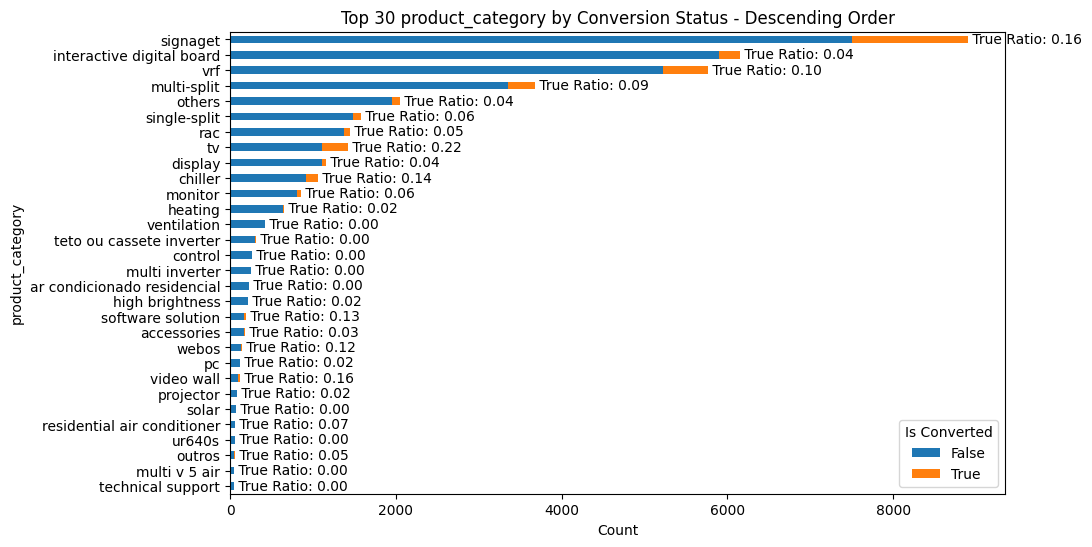

product_category: 38154
<Top 15 by Total Count in product_category:>
    signaget                               True Ratio : 0.16, Total Count : 8905
    interactive digital board              True Ratio : 0.04, Total Count : 6154
    vrf                                    True Ratio : 0.10, Total Count : 5767
    multi-split                            True Ratio : 0.09, Total Count : 3679
    others                                 True Ratio : 0.04, Total Count : 2047
    single-split                           True Ratio : 0.06, Total Count : 1574
    rac                                    True Ratio : 0.05, Total Count : 1447
    tv                                     True Ratio : 0.22, Total Count : 1423
    display                                True Ratio : 0.04, Total Count : 1156
    chiller                                True Ratio : 0.14, Total Count : 1063
    monitor                                True Ratio : 0.06, Total Count : 852
    heating                              

In [ ]:
#'product_category'비슷한 값 치환 후 target비율 확인

visualize_top_categories_by_conversion_with_ratio(df_train, 'product_category', top_n=30, target='is_converted')

#train_data내에서 product_category의 target비율 상위 30개 확인 (True Ratio 기준 상위 30개, 데이터 수 기준 상위 30개)

show_binary_ratio_sorted(df_train, ['product_category'], target='is_converted',n=30)

###**비슷한 값 치환**  
Fold #1  
[Train] Fold #1 ACC: 0.9907, PRE: 0.9012, REC: 0.9970, F1: 0.9467  
[Valid] Fold #1 ACC: 0.9525, PRE: 0.6451, REC: 0.9481, F1: 0.7677  
Fold #2  
[Train] Fold #2 ACC: 0.9892, PRE: 0.8865, REC: 0.9978, F1: 0.9389  
[Valid] Fold #2 ACC: 0.9538, PRE: 0.6543, REC: 0.9383, F1: 0.7710  
Fold #3  
[Train] Fold #3 ACC: 0.9866, PRE: 0.8623, REC: 0.9978, F1: 0.9251  
[Valid] Fold #3 ACC: 0.9533, PRE: 0.6498, REC: 0.9459, F1: 0.7704  
Fold #4  
[Train] Fold #4 ACC: 0.9877, PRE: 0.8728, REC: 0.9968, F1: 0.9307  
[Valid] Fold #4 ACC: 0.9542, PRE: 0.6540, REC: 0.9491, F1: 0.7744  
Fold #5  
[Train] Fold #5 ACC: 0.9890, PRE: 0.8840, REC: 0.9976, F1: 0.9373  
[Valid] Fold #5 ACC: 0.9557, PRE: 0.6651, REC: 0.9372, F1: 0.7781  
**Avg. F1 of validset: 0.7723221121531443**  

---
###**product_category drop**
Fold #1  
[Train] Fold #1 ACC: 0.9927, PRE: 0.9226, REC: 0.9959, F1: 0.9578  
[Valid] Fold #1 ACC: 0.9514, PRE: 0.6396, REC: 0.9470, F1: 0.7635  
Fold #2  
[Train] Fold #2 ACC: 0.9897, PRE: 0.8914, REC: 0.9970, F1: 0.9413  
[Valid] Fold #2 ACC: 0.9533, PRE: 0.6514, REC: 0.9383, F1: 0.7690  
Fold #3  
[Train] Fold #3 ACC: 0.9872, PRE: 0.8679, REC: 0.9976, F1: 0.9282  
[Valid] Fold #3 ACC: 0.9524, PRE: 0.6452, REC: 0.9448, F1: 0.7668  
Fold #4  
[Train] Fold #4 ACC: 0.9879, PRE: 0.8751, REC: 0.9968, F1: 0.9320  
[Valid] Fold #4 ACC: 0.9551, PRE: 0.6594, REC: 0.9470, F1: 0.7774  
Fold #5  
[Train] Fold #5 ACC: 0.9878, PRE: 0.8729, REC: 0.9976, F1: 0.9311  
[Valid] Fold #5 ACC: 0.9548, PRE: 0.6598, REC: 0.9383, F1: 0.7748  
**Avg. F1 of validset: 0.7703025551451175**  